In [35]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.client import device_lib
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from math import isnan
from numpy import average
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import warnings
size = 224
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [32]:
def keras2TFlite(model_path,name):
    #load a pre-trained model
    with tf.device('/gpu:0'):
        model = tf.keras.models.load_model(model_path)
        #convert the model
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        #save the converted model
        with open('../../model/classification/tflite/'+name+'.tflite', 'wb') as f:
            f.write(tflite_model)
        print('Model converted successfully')

def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

def TFLiteInference(model_path, name, x_test, y_test):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    with tf.device('/gpu:0'):
        input_index = interpreter.get_input_details()[0]['index']
        output_index  = interpreter.get_output_details()[0]['index']
        
        sum_correct = 0
        sum_time=0
        predict=[]
        for idx, data in tqdm(enumerate(zip(x_test,y_test))):
            img = data[0]
            label = data[1]
            img= img.astype(np.float32)
            img = tf.expand_dims(img, axis=0)
            
            interpreter.set_tensor(input_index, img)
            start_time = time.time()
            interpreter.invoke()
            
            output = interpreter.get_tensor(output_index)
            stop_time = time.time()
            sum_time += stop_time-start_time
            
            if (output[0][0]>0.34) == label:
                sum_correct += 1.0
            predict.append(output[0][0])
            mean_acc=sum_correct/float(idx+1)
            mean_time=sum_time/float(idx+1)
        print('Model: ',name)
        print('Mean Accuracy: ',mean_acc)
        print('Mean Inference Time: ',mean_time)
        return predict
# keras2TFlite('../../model/classification/MobileNetV2_checkpoints.h5','MobileNetV2')
# keras2TFlite('../../model/classification/MobileNetV1_acc_checkpoints.h5','MobileNetV1')
# keras2TFlite('../../model/classification/DenseNet121_checkpoints.h5','DenseNet121')
# keras2TFlite('../../model/classification/EfficientNetV2B0_checkpoints.h5','EfficientNetV2B0')
# keras2TFlite('../../model/classification/NASNetMobile_checkpoints.h5','NASNetMobile')
# keras2TFlite('../../model/classification/ResNet50_checkpoints.h5','ResNet50')        

In [ ]:

test_df = pd.read_csv(
    '../../data/classificationDDH/test_aug_classification_dataset.csv')


test_img_list = test_df['file name'].to_list()
test_label_list = test_df['standard class'].to_list()
test_case_list = test_df['case'].to_list()
test_img_path = '../../data/classificationDDH/aug_dataset/test/'


x_test = np.zeros((len(test_img_list), size, size, 3), dtype=np.uint8)
for i in tqdm(range(len(test_img_list))):
    x_test[i] = np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/'+test_img_list[i]).resize((size, size)))
y_test = np.array(test_label_list)

In [33]:
MobileNetV2_pre=TFLiteInference('../../model/classification/tflite/MobileNetV2.tflite','MobileNetV2',x_test,y_test)
MobileNetV1_pre=TFLiteInference('../../model/classification/tflite/MobileNetV1.tflite','MobileNetV1',x_test,y_test)
DenseNet121_pre=TFLiteInference('../../model/classification/tflite/DenseNet121.tflite','DenseNet121',x_test,y_test)
EfficientNetV2B0_pre=TFLiteInference('../../model/classification/tflite/EfficientNetV2B0.tflite','EfficientNetV2B0',x_test,y_test)
NASNetMobile_pre=TFLiteInference('../../model/classification/tflite/NASNetMobile.tflite','NASNetMobile',x_test,y_test)
ResNet50_pre=TFLiteInference('../../model/classification/tflite/ResNet50.tflite','ResNet50',x_test,y_test)


0it [00:00, ?it/s]

Model:  MobileNetV2
Mean Accuracy:  0.8564441887226697
Mean Inference Time:  0.015173011805574968


0it [00:00, ?it/s]

Model:  MobileNetV1
Mean Accuracy:  0.877445339470656
Mean Inference Time:  0.010668179382526148


0it [00:00, ?it/s]

Model:  DenseNet121
Mean Accuracy:  0.8340046029919448
Mean Inference Time:  0.14166732706875465


0it [00:00, ?it/s]

Model:  EfficientNetV2B0
Mean Accuracy:  0.8317031070195627
Mean Inference Time:  0.019987125391241322


0it [00:00, ?it/s]

Model:  NASNetMobile
Mean Accuracy:  0.8610471806674338
Mean Inference Time:  0.05074461666980739


0it [00:00, ?it/s]

Model:  ResNet50
Mean Accuracy:  0.85385500575374
Mean Inference Time:  0.1901562161083463


(0.0, 1.0)

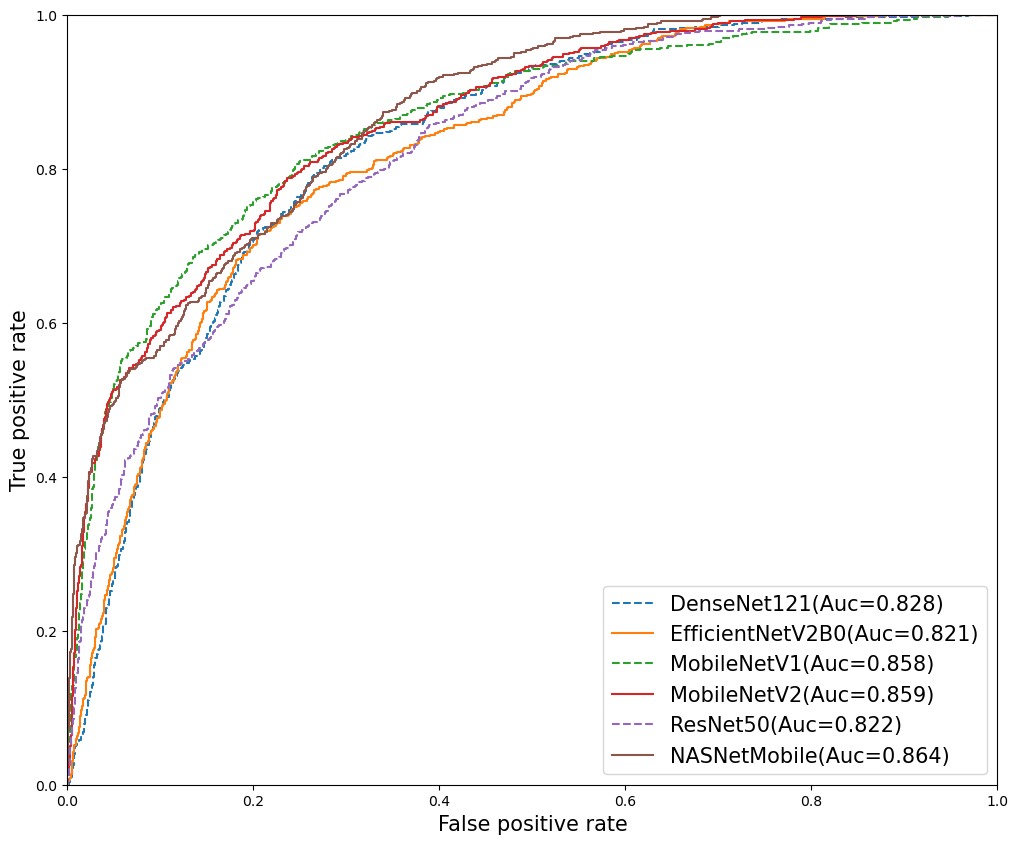

In [36]:
MobileNetV2_fper,MobileNetV2_tper, thresholds = roc_curve(y_test, MobileNetV2_pre)
MobileNetV1_fper,MobileNetV1_tper, thresholds = roc_curve(y_test, MobileNetV1_pre)
DenseNet121_fper,DenseNet121_tper, thresholds = roc_curve(y_test, DenseNet121_pre)
EfficientNetV2B0_fper,EfficientNetV2B0_tper, thresholds = roc_curve(y_test, EfficientNetV2B0_pre)
NASNetMobile_fper,NASNetMobile_tper, thresholds = roc_curve(y_test, NASNetMobile_pre)
ResNet50_fper,ResNet50_tper, thresholds = roc_curve(y_test, ResNet50_pre)
MobileNetV2_auc_score=roc_auc_score(y_test, MobileNetV2_pre)
MobileNetV1_auc_score=roc_auc_score(y_test, MobileNetV1_pre)
DenseNet121_auc_score=roc_auc_score(y_test, DenseNet121_pre)
EfficientNetV2B0_auc_score=roc_auc_score(y_test, EfficientNetV2B0_pre)
NASNetMobile_auc_score=roc_auc_score(y_test, NASNetMobile_pre)
ResNet50_auc_score=roc_auc_score(y_test, ResNet50_pre)
plt.figure(figsize=(12,10))
plt.plot(DenseNet121_fper, DenseNet121_tper,label='DenseNet121(Auc='+str(round(DenseNet121_auc_score, 3))+')',linestyle='--')
plt.plot(EfficientNetV2B0_fper, EfficientNetV2B0_tper,label='EfficientNetV2B0(Auc='+str(round(EfficientNetV2B0_auc_score, 3))+')')
plt.plot(MobileNetV1_fper, MobileNetV1_tper,label='MobileNetV1(Auc='+str(round(MobileNetV1_auc_score, 3))+')',linestyle='--')
plt.plot(MobileNetV2_fper,MobileNetV2_tper,label='MobileNetV2(Auc='+str(round(MobileNetV2_auc_score, 3))+')')
plt.plot(ResNet50_fper,ResNet50_tper,label='ResNet50(Auc='+str(round(ResNet50_auc_score, 3))+')',linestyle='--')
plt.plot(NASNetMobile_fper,NASNetMobile_tper,label='NASNetMobile(Auc='+str(round(NASNetMobile_auc_score, 3))+')')
plt.legend(fontsize=15)
plt.xlabel('False positive rate',size=15)
plt.ylabel('True positive rate',size=15)
plt.xlim([0, 1])      # X축의 범위: [xmin, xmax]
plt.ylim([0, 1]) 


In [42]:

warnings.filterwarnings('ignore')
def weight_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn*0.25)
    specificity = tn / (tn + fp)
    precision=tp/ (tp+fp)
    f1 = f1_score(y_true, y_pred,average='micro')
    weight=f1
    
    return weight
# Define a function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [weight_metrics(y_true, (y_scores >= t).astype(int)) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold
MobileNetV2_pre=np.array(MobileNetV2_pre)
MobileNetV1_pre=np.array(MobileNetV1_pre)
DenseNet121_pre=np.array(DenseNet121_pre)
EfficientNetV2B0_pre=np.array(EfficientNetV2B0_pre)
NASNetMobile_pre=np.array(NASNetMobile_pre)
ResNet50_pre=np.array(ResNet50_pre)

# Find optimal threshold for each model
MobileNetV2_optimal_threshold = find_optimal_threshold(y_test, MobileNetV2_pre)
MobileNetV1_optimal_threshold = find_optimal_threshold(y_test, MobileNetV1_pre)
DenseNet121_optimal_threshold = find_optimal_threshold(y_test, DenseNet121_pre)
EfficientNetV2B0_optimal_threshold = find_optimal_threshold(y_test, EfficientNetV2B0_pre)
NASNetMobile_optimal_threshold = find_optimal_threshold(y_test, NASNetMobile_pre)
ResNet50_optimal_threshold = find_optimal_threshold(y_test, ResNet50_pre)
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn*0.25)
    specificity = tn / (tn + fp)
    precision=tp / (tp+fp)
    accuracy = accuracy_score(y_true, y_pred)
    f1 =f1_score(y_true, y_pred,average='micro')
    return sensitivity, specificity, accuracy, f1

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper
def bootstrap_f1_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred,average='micro'))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper


def performance_ci(model_name,test,predict,threshold):
    ci_auc_lower, ci_auc_upper = bootstrap_ci(roc_auc_score, test, predict)
    ci_sensitivity_lower, ci_sensitivity_upper = bootstrap_f1_ci(recall_score, test, (predict >threshold).astype(int))
    ci_specificity_lower, ci_specificity_upper = bootstrap_ci(
    lambda x, y: confusion_matrix(x, y).ravel()[0] / (confusion_matrix(x, y).ravel()[0] + confusion_matrix(x, y).ravel()[1]),
    test,
    (predict > threshold).astype(int)
)
    ci_accuracy_lower, ci_accuracy_upper = bootstrap_ci(accuracy_score, test, (predict >threshold).astype(int))
    ci_f1_lower, ci_f1_upper = bootstrap_f1_ci(f1_score, test, (predict >threshold).astype(int))
    print("{}: AUC={}({}-{}), Sensitivity={}({}-{}), Specificity={}({}-{}), Accuracy={}({}-{}), F1-Score={}({}-{})".format(model_name,round((ci_auc_upper+ci_auc_lower)/2,3),round(ci_auc_lower,3),round(ci_auc_upper,3),round((ci_sensitivity_upper+ci_sensitivity_lower)/2,3),round(ci_sensitivity_lower,3), round(ci_sensitivity_upper,3),round((ci_specificity_upper+ci_specificity_lower)/2,3),round(ci_specificity_lower,3),round(ci_specificity_upper,3), round((ci_accuracy_upper+ci_accuracy_lower)/2,3),round(ci_accuracy_lower,3),round(ci_accuracy_upper,3), round((ci_f1_upper+ci_f1_lower)/2,3),round(ci_f1_lower,3),round(ci_f1_upper,3)))
    
# Calculate metrics for each model
MobileNetV2_sensitivity, MobileNetV2_specificity, MobileNetV2_accuracy, MobileNetV2_f1 = calculate_metrics(y_test, (MobileNetV2_pre > MobileNetV2_optimal_threshold ).astype(int))
MobileNetV1_sensitivity, MobileNetV1_specificity, MobileNetV1_accuracy, MobileNetV1_f1 = calculate_metrics(y_test, (MobileNetV1_pre > MobileNetV1_optimal_threshold).astype(int))
DenseNet121_sensitivity, DenseNet121_specificity, DenseNet121_accuracy, DenseNet121_f1 = calculate_metrics(y_test, (DenseNet121_pre > DenseNet121_optimal_threshold).astype(int))
EfficientNetV2B0_sensitivity, EfficientNetV2B0_specificity, EfficientNetV2B0_accuracy, EfficientNetV2B0_f1 = calculate_metrics(y_test, (EfficientNetV2B0_pre > EfficientNetV2B0_optimal_threshold).astype(int))
NASNetMobile_sensitivity, NASNetMobile_specificity, NASNetMobile_accuracy, NASNetMobile_f1 = calculate_metrics(y_test, (NASNetMobile_pre > NASNetMobile_optimal_threshold).astype(int))
ResNet50_sensitivity, ResNet50_specificity, ResNet50_accuracy, ResNet50_f1 = calculate_metrics(y_test, (ResNet50_pre > ResNet50_optimal_threshold).astype(int))


print("model performance(95% CI)")
performance_ci('MobileNetV2',y_test,MobileNetV2_pre,MobileNetV2_optimal_threshold)
performance_ci('MobileNetV1',y_test,MobileNetV1_pre,MobileNetV1_optimal_threshold)
performance_ci('DenseNet121',y_test,DenseNet121_pre,DenseNet121_optimal_threshold)
performance_ci('EfficientNetV2B0',y_test,EfficientNetV2B0_pre,EfficientNetV2B0_optimal_threshold)
performance_ci('NASNetMobile',y_test,NASNetMobile_pre,NASNetMobile_optimal_threshold)
performance_ci('ResNet50',y_test,ResNet50_pre,ResNet50_optimal_threshold)


model performance(95% CI)
MobileNetV2: AUC=0.859(0.844-0.875), Sensitivity=0.879(0.869-0.89), Specificity=0.973(0.967-0.979), Accuracy=0.879(0.868-0.89), F1-Score=0.879(0.868-0.891)
MobileNetV1: AUC=0.857(0.84-0.874), Sensitivity=0.88(0.869-0.89), Specificity=0.959(0.953-0.966), Accuracy=0.88(0.869-0.891), F1-Score=0.879(0.868-0.89)
DenseNet121: AUC=0.827(0.812-0.843), Sensitivity=0.835(0.822-0.848), Specificity=0.958(0.951-0.965), Accuracy=0.835(0.823-0.847), F1-Score=0.836(0.824-0.848)
EfficientNetV2B0: AUC=0.821(0.802-0.839), Sensitivity=0.839(0.827-0.851), Specificity=0.943(0.935-0.951), Accuracy=0.839(0.826-0.852), F1-Score=0.839(0.826-0.851)
NASNetMobile: AUC=0.863(0.848-0.879), Sensitivity=0.88(0.87-0.891), Specificity=0.974(0.968-0.98), Accuracy=0.88(0.87-0.89), F1-Score=0.881(0.871-0.892)
ResNet50: AUC=0.823(0.806-0.84), Sensitivity=0.856(0.845-0.868), Specificity=0.969(0.963-0.975), Accuracy=0.857(0.845-0.868), F1-Score=0.857(0.846-0.869)


In [41]:
MobileNetV2_sensitivity

0.7416413373860182

In [38]:
test

NameError: name 'test' is not defined